<a href="https://colab.research.google.com/github/rabihchamas/U-net-image-segmentation/blob/main/U_net_MRI_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras import optimizers
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Declare Paths
parent_path = '/content/drive/MyDrive'
dir = 'emidac_prjct'
path = os.path.join(parent_path, dir)

train_path = os.path.join(path, 'Training')
test_path = os.path.join(path, 'Testing')

img_train = os.path.join(train_path,'Images')
cntr_train = os.path.join(train_path,'Contours')

img_test = os.path.join(test_path,'Images')
cntr_test = os.path.join(test_path,'Contours')

In [ ]:
# Patient Id List
ids = os.listdir(img_train)

In [ ]:
import nibabel as nib
import cv2

X = []
Y = []
for n, id_ in enumerate(ids):
    # Load images
    img = nib.load(img_train + '/' + id_).get_fdata()
    for sl in range(img.shape[2]):
      x_img = cv2.resize(img[:,:,sl], (128, 128))
      X.append(x_img)
    # Load masks
    mask = nib.load(cntr_train+ '/' + id_).get_fdata()
    for sl in range(img.shape[2]):
      x_mask = cv2.resize(mask[:,:,sl], (128, 128))
      Y.append(np.floor(x_mask))

In [ ]:
# Resize the images and mask
X = np.array(X)
Y = np.array(Y)

a, b, c = X.shape
X.resize(a,b,c,1)
Y.resize(a,b,c,1)
print(X.shape)
print(Y.shape)

(708, 128, 128, 1)
(708, 128, 128, 1)


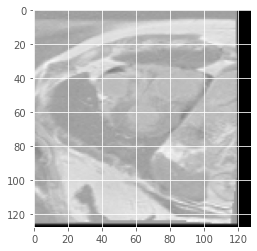

In [ ]:
# Show an image in the data
ind = 560
plt.imshow(X[ind,:,:, 0], cmap='gray')

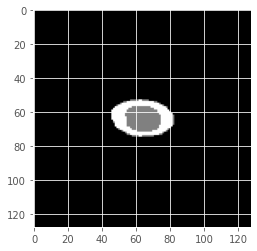

In [ ]:
# Show its corresponding mask
plt.imshow(Y[ind,:,:,0] , cmap='gray')

In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)

# Define U-net Model

In [ ]:
# define conv block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [ ]:
# define the U net 
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    c1 = conv2d_block(c1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    c2 = conv2d_block(c2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c3 = conv2d_block(c3, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c4 = conv2d_block(c4, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    c5 = conv2d_block(c5, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c6 = conv2d_block(c6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c7 = conv2d_block(c7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    c8 = conv2d_block(c8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    c9 = conv2d_block(c9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# Input size
im_width = 128
im_height = 128


# Instantiate and compile Unet model
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_37 (BatchN  (None, 128, 128, 16  64         ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# Fit the model
results = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
20/20 [==============================] - 8s 248ms/step - loss: 0.0000e+00 - accuracy: 0.8697 - val_loss: 0.0000e+00 - val_accuracy: 0.8945
Epoch 2/50
20/20 [==============================] - 4s 215ms/step - loss: 0.0000e+00 - accuracy: 0.9440 - val_loss: 0.0000e+00 - val_accuracy: 0.5102
Epoch 3/50
20/20 [==============================] - 4s 214ms/step - loss: 0.0000e+00 - accuracy: 0.9646 - val_loss: 0.0000e+00 - val_accuracy: 0.3106
Epoch 4/50
20/20 [==============================] - 4s 214ms/step - loss: 0.0000e+00 - accuracy: 0.9778 - val_loss: 0.0000e+00 - val_accuracy: 0.5985
Epoch 5/50
20/20 [==============================] - 4s 214ms/step - loss: 0.0000e+00 - accuracy: 0.9795 - val_loss: 0.0000e+00 - val_accuracy: 0.9549
Epoch 6/50
20/20 [==============================] - 4s 216ms/step - loss: 0.0000e+00 - accuracy: 0.9806 - val_loss: 0.0000e+00 - val_accuracy: 0.9677
Epoch 7/50
20/20 [==============================] - 4s 215ms/step - loss: 0.0000e+00 - accuracy: 0.9

In [ ]:
# Pedict the validation set using the model
pred = model.predict(X_valid, verbose=1)

3/3 [==============================] - 1s 78ms/step


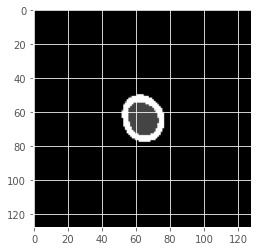

In [ ]:
# Show a predicted mask
ind = 5
plt.imshow(pred[ind,:,:,0]  , cmap='gray')

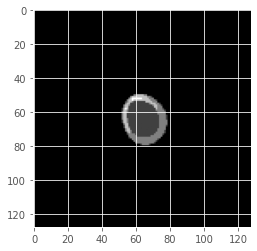

In [ ]:
# Original Mask of the image
plt.imshow(y_valid[ind,:,:,0]  , cmap='gray')